In [45]:
import numpy as np
import os
import re  # for regular expressions

# Constants
directory_path = '/Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2'
output_file_path = os.path.join(directory_path, 'summary_results.txt')
wavelengths = [1540, 1550, 1560]
waveguide_labels = {'1': 0.54, '2': 1.14, '3': 2.34, '4': 3.54}

# Function to extract material and waveguide label from filename
def extract_info_from_filename(filename):
    match = re.search(r"C-([A-Z\-]+)-\d*-*([1-4])_", filename.upper())
    if match:
        material, waveguide = match.groups()
        return material, waveguide_labels[waveguide]
    return None, None

# Extract and save results
with open(output_file_path, 'w') as outfile:
    outfile.write("Material\tWaveguide_Length(cm)\tWavelength\tPower(dB)\n")

    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory_path, filename)
            
            # Diagnostic message
            print(f"Processing file: {filename}")

            # Determine the number of header lines to skip
            with open(file_path, 'r') as file:
                lines_to_skip = 0
                for line in file:
                    if 'Wavelength [nm]' in line:
                        lines_to_skip += 1
                        break
                    lines_to_skip += 1

            try:
                # Load the data, skipping the determined number of rows
                data = np.loadtxt(file_path, delimiter='\t', skiprows=lines_to_skip)
                
                if len(data.shape) == 1:
                    print(f"Warning: Data in {filename} is not 2D. Skipping this file.")
                    continue

                wvl_data = data[:, 0]
                power_data = data[:, 1]

            except Exception as e:
                print(f"Error processing file {filename}: {e}")
                continue  # Skip to the next iteration
            
            # Extract material and waveguide label from filename
            material, waveguide_length = extract_info_from_filename(filename)
            if material is None or waveguide_length is None:
                # Diagnostic message
                print(f"Skipping file {filename} due to pattern mismatch.")
                continue  # Skip if the pattern doesn't match

            for wvl in wavelengths:
                # Extracting the power value corresponding to the wavelength
                index = np.where(wvl_data == wvl)
                if index[0].size != 0:
                    power = power_data[index[0][0]]
                    outfile.write(f"{material}\t{waveguide_length}\t{wvl}\t{power:.2f}\n")

print(f"Results saved to {output_file_path}")


Processing file: summary_results.txt
Processing file: RawData_StucNum_C-RIB-450-4_LowRes_1.txt
Processing file: RawData_StucNum_C-RIB-450-3_LowRes_1.txt
Processing file: RawData_StucNum_C-RIB-450-2_LowRes_1.txt
Processing file: RawData_StucNum_C-TE-SiN-4_LowRes_2.txt
Processing file: RawData_StucNum_C-TE-SiN-3_LowRes_2.txt
Processing file: RawData_StucNum_C-STRIP-500-1_LowRes_1.txt
Processing file: RawData_StucNum_C-TE-SiN-2_LowRes_2.txt
Processing file: RawData_StucNum_C-STRIP-500-3_LowRes_1.txt
Processing file: RawData_StucNum_C-STRIP-500-4_LowRes_1.txt
Processing file: RawData_StucNum_C-TE-SiN-1_LowRes_2.txt
Processing file: RawData_StucNum_C-STRIP-500-2_LowRes_1.txt
Processing file: RawData_StucNum_C-RIB-450-1_LowRes_1.txt
Results saved to /Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2/summary_results.txt


<ipython-input-45-bac216f241d1>:41: UserWarning: loadtxt: Empty input file: "/Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2/summary_results.txt"
  data = np.loadtxt(file_path, delimiter='\t', skiprows=lines_to_skip)


In [46]:
import os

# Constants
directory_path = '/Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2'
output_file_path = os.path.join(directory_path, 'summary_results.txt')

# Load the data from the file
data = []
with open(output_file_path, 'r') as file:
    headers = file.readline()  # Skip headers
    for line in file:
        material, waveguide_length, wavelength, power = line.strip().split("\t")
        data.append({
            "Material": material,
            "Waveguide_Length(cm)": float(waveguide_length),
            "Wavelength": int(wavelength),
            "Power(dB)": float(power)
        })

# Sorting the data
data.sort(key=lambda x: (x["Material"], x["Waveguide_Length(cm)"], x["Wavelength"]))

# Write the sorted data back to the file
with open(output_file_path, 'w') as outfile:
    outfile.write("Material\tWaveguide_Length(cm)\tWavelength\tPower(dB)\n")
    for entry in data:
        outfile.write(f"{entry['Material']}\t{entry['Waveguide_Length(cm)']}\t{entry['Wavelength']}\t{entry['Power(dB)']:.2f}\n")

print(f"Sorted results saved to {output_file_path}")


Sorted results saved to /Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2/summary_results.txt


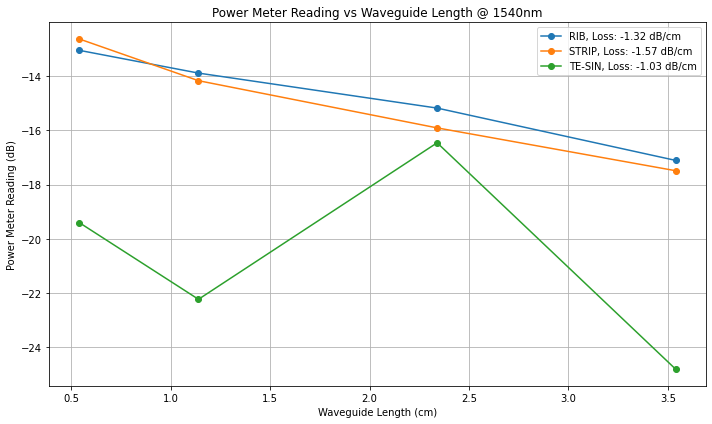

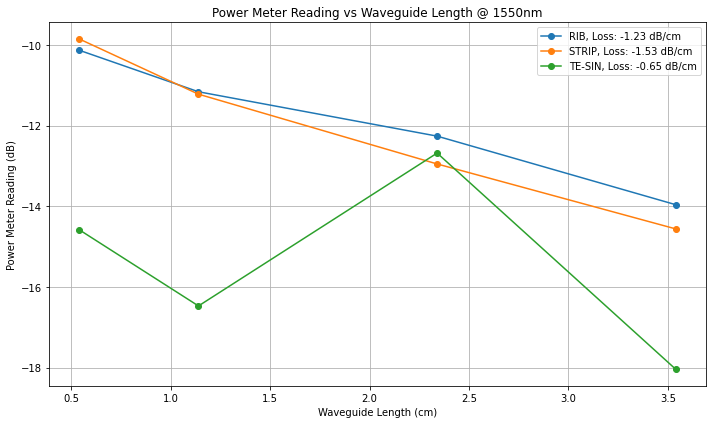

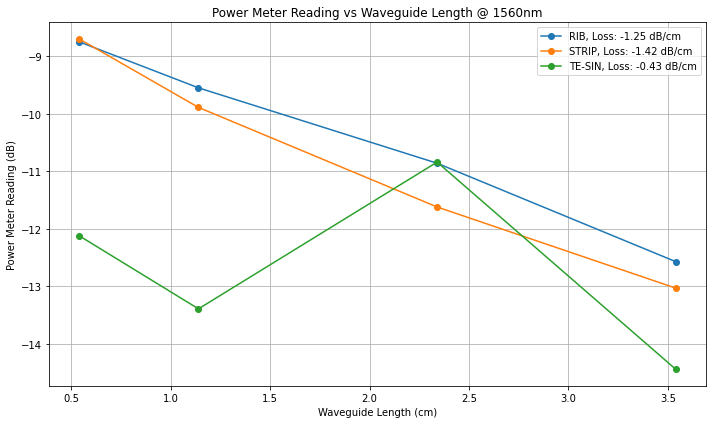

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Constants
directory_path = '/Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2'
file_path = os.path.join(directory_path, 'summary_results.txt')
loss_output_path = os.path.join(directory_path, 'propagation_losses.txt')
coupling_losses_path = os.path.join(directory_path, 'coupling_losses.txt')

# Data extraction
wavelengths = [1540, 1550, 1560]
data = {}

with open(file_path, 'r') as file:
    headers = file.readline()  # Skip headers
    for line in file:
        material, waveguide_length, wavelength, power = line.strip().split("\t")
        key = (material, int(wavelength))
        if key not in data:
            data[key] = []
        data[key].append((float(waveguide_length), float(power)))

loss_data = {}  # To store propagation loss results
coupling_data = {}  # To store coupling loss results

# Plotting and calculating
for wavelength in wavelengths:
    plt.figure(figsize=(10, 6))
    for key, values in data.items():
        material, wvl = key
        if wvl == wavelength:
            sorted_values = sorted(values, key=lambda x: x[0])
            waveguide_lengths = [x[0] for x in sorted_values]
            power_readings = [x[1] for x in sorted_values]

            # Linear regression
            slope, intercept = np.polyfit(waveguide_lengths, power_readings, 1)
            coupling_loss = intercept / 2

            # Save loss data
            loss_data[(material, wvl)] = slope
            coupling_data[(material, wvl)] = coupling_loss

            # Plot
            plt.plot(waveguide_lengths, power_readings, 'o-', label=f"{material}, Loss: {slope:.2f} dB/cm")

    # Customize the plot
    plt.xlabel('Waveguide Length (cm)')
    plt.ylabel('Power Meter Reading (dB)')
    plt.title(f'Power Meter Reading vs Waveguide Length @ {wavelength}nm')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot as PNG
    plt.savefig(os.path.join(directory_path, f"plot_{wavelength}nm.png"))

    plt.show()

# Save propagation and coupling loss results
with open(loss_output_path, 'w') as loss_file, open(coupling_losses_path, 'w') as coupling_file:
    loss_file.write("Material\tWavelength(nm)\tPropagation_Loss(dB/cm)\n")
    coupling_file.write("Material\tWavelength(nm)\tCoupling_Loss(dB)\n")
    
    for key in sorted(loss_data.keys()):
        material, wvl = key
        loss_file.write(f"{material}\t{wvl}\t{loss_data[key]:.2f}\n")
        coupling_file.write(f"{material}\t{wvl}\t{coupling_data[key]:.2f}\n")



Processing file: summary_results.txt
Processing file: RawData_StucNum_C-RIB-450-4_LowRes_1.txt
Processing file: RawData_StucNum_C-RIB-450-3_LowRes_1.txt
Processing file: propagation_losses.txt
Processing file: RawData_StucNum_C-RIB-450-2_LowRes_1.txt
Processing file: RawData_StucNum_C-TE-SiN-4_LowRes_2.txt
Processing file: RawData_StucNum_C-TE-SiN-3_LowRes_2.txt
Processing file: RawData_StucNum_C-STRIP-500-1_LowRes_1.txt
Processing file: RawData_StucNum_C-TE-SiN-2_LowRes_2.txt
Processing file: RawData_StucNum_C-STRIP-500-3_LowRes_1.txt
Processing file: RawData_StucNum_C-STRIP-500-4_LowRes_1.txt
Processing file: RawData_StucNum_C-TE-SiN-1_LowRes_2.txt
Processing file: RawData_StucNum_C-STRIP-500-2_LowRes_1.txt
Processing file: coupling_losses.txt
Processing file: RawData_StucNum_C-RIB-450-1_LowRes_1.txt


<ipython-input-49-3410d493153a>:43: UserWarning: loadtxt: Empty input file: "/Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2/summary_results.txt"
  data = np.loadtxt(file_path, delimiter='\t', skiprows=lines_to_skip)
<ipython-input-49-3410d493153a>:43: UserWarning: loadtxt: Empty input file: "/Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2/propagation_losses.txt"
  data = np.loadtxt(file_path, delimiter='\t', skiprows=lines_to_skip)
<ipython-input-49-3410d493153a>:43: UserWarning: loadtxt: Empty input file: "/Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2/coupling_losses.txt"
  data = np.loadtxt(file_path, delimiter='\t', skiprows=lines_to_skip)


Results saved to /Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2/summary_results.csv
Plots saved to /Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2/band_plots.png


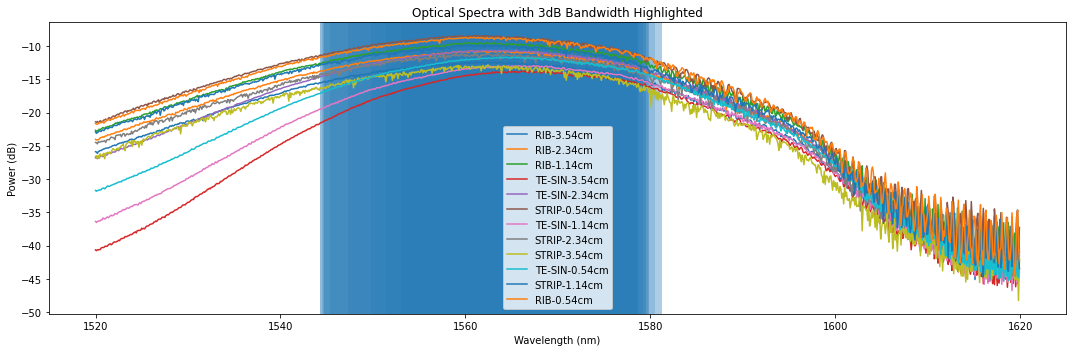

In [49]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import pandas as pd

# Constants
directory_path = '/Users/caroline_physic/Desktop/chip learning/6733/TEST_29 Sept Lab Session/Reticle_0_-2'
output_file_path = os.path.join(directory_path, 'summary_results.csv')
plot_filename = os.path.join(directory_path, 'band_plots.png')
waveguide_labels = {'1': 0.54, '2': 1.14, '3': 2.34, '4': 3.54}

# Extract information from filename
def extract_info_from_filename(filename):
    match = re.search(r"C-([A-Z\-]+)-\d*-*([1-4])_", filename.upper())
    if match:
        material, waveguide = match.groups()
        return material, waveguide_labels[waveguide]
    return None, None


results = []

# Create a plot for each file
fig, axs = plt.subplots(figsize=(15, 5))

for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory_path, filename)
        print(f"Processing file: {filename}")

        # Determine the number of header lines to skip
        with open(file_path, 'r') as file:
            lines_to_skip = 0
            for line in file:
                if 'Wavelength [nm]' in line:
                    lines_to_skip += 1
                    break
                lines_to_skip += 1

        try:
            # Load the data, skipping the determined number of rows
            data = np.loadtxt(file_path, delimiter='\t', skiprows=lines_to_skip)

            if len(data.shape) == 1:
                print(f"Warning: Data in {filename} is not 2D. Skipping this file.")
                continue

            wvl_data = data[:, 0]
            power_data = data[:, 1]

        except Exception as e:
            print(f"Error processing file {filename}: {e}")
            continue

        # Extract material and waveguide label from filename
        material, waveguide_length = extract_info_from_filename(filename)
        if material is None or waveguide_length is None:
            print(f"Skipping file {filename} due to pattern mismatch.")
            continue

        # Derive the center wavelength and bandwidth
        center_wavelength = wvl_data[np.argmax(power_data)]
        half_max_power = np.max(power_data) - 3  # 3dB point from peak
        bandwidth_indices = np.where(power_data >= half_max_power)
        bandwidth = wvl_data[bandwidth_indices[-1][-1]] - wvl_data[bandwidth_indices[0][0]]

        results.append((material, waveguide_length, center_wavelength, bandwidth))

        # Plot the spectrum with 3dB bandwidth highlighted
        axs.plot(wvl_data, power_data, label=f"{material}-{waveguide_length}cm")
        axs.axvspan(wvl_data[bandwidth_indices[0][0]], wvl_data[bandwidth_indices[-1][-1]], alpha=0.2)

# Save plot to file
axs.legend()
axs.set_xlabel("Wavelength (nm)")
axs.set_ylabel("Power (dB)")
axs.set_title("Optical Spectra with 3dB Bandwidth Highlighted")
plt.tight_layout()
plt.savefig(plot_filename)

# Sort the results by material
sorted_results = sorted(results, key=lambda x: x[0])

# Write sorted results to CSV
with open(output_file_path, 'w') as outfile:
    outfile.write("Material,Waveguide_Length(cm),Center_Wavelength(nm),3dB_Bandwidth(nm)\n")
    for result in sorted_results:
        outfile.write(f"{result[0]},{result[1]},{result[2]:.2f},{result[3]:.2f}\n")

print(f"Results saved to {output_file_path}")
print(f"Plots saved to {plot_filename}")
